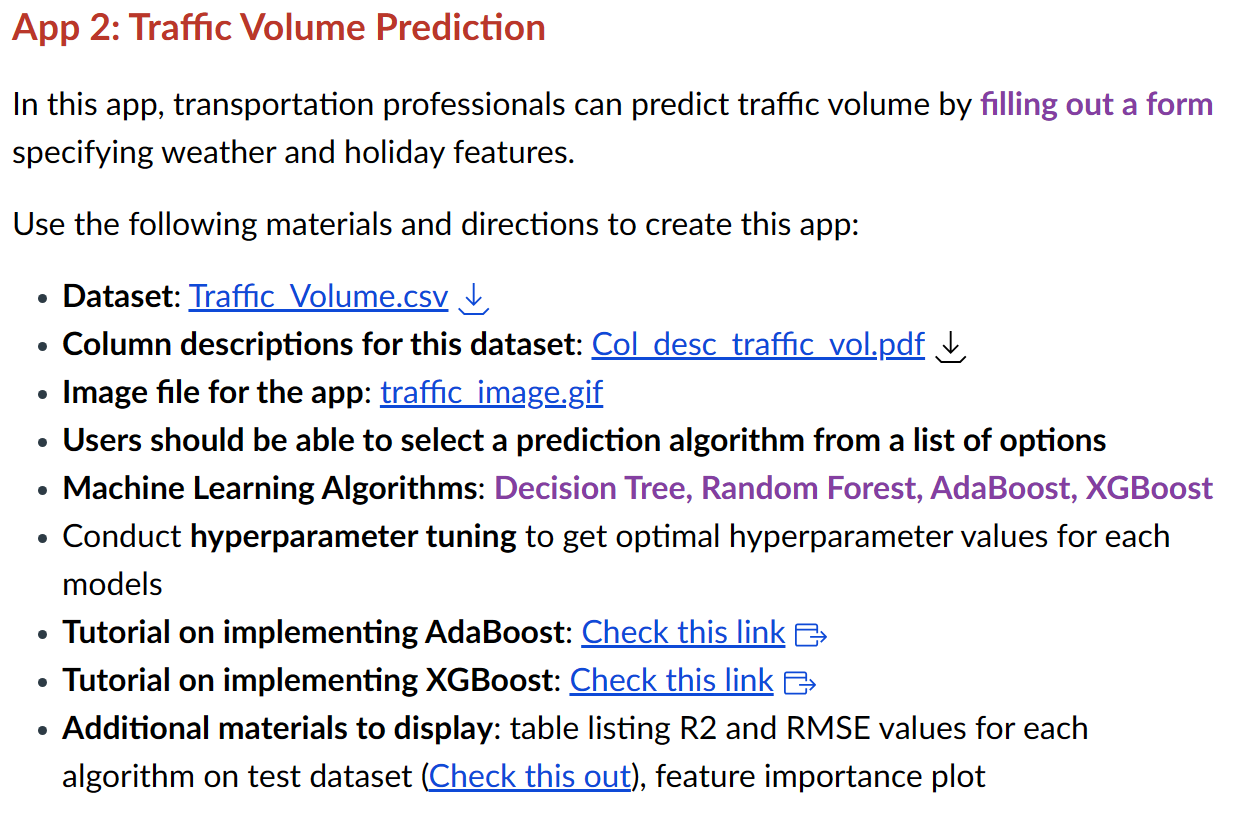

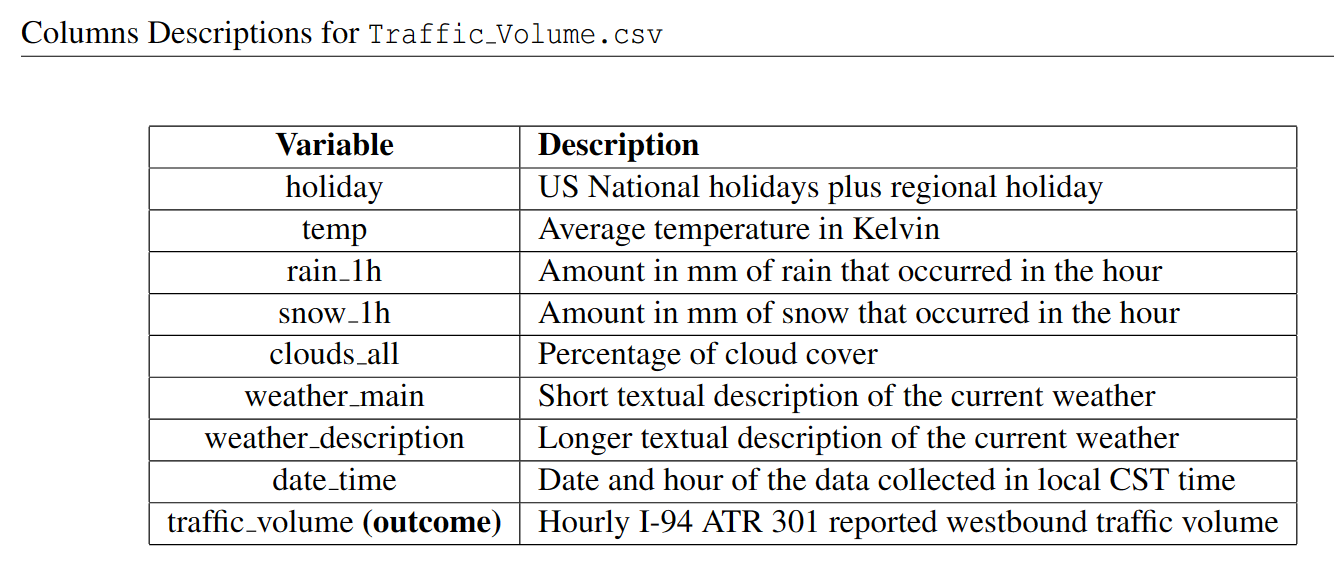

In [1]:
import pandas as pd                  # Pandas
import numpy as np                   # Numpy
from matplotlib import pyplot as plt # Matplotlib

# Package to implement ML Algorithms
import sklearn
from sklearn.tree import DecisionTreeRegressor     # Decision Tree
from sklearn.ensemble import RandomForestRegressor # Random Forest
from sklearn.ensemble import AdaBoostRegressor     # AdaBoost
from xgboost import XGBRegressor                   # XGBoost

# Package for data partitioning
from sklearn.model_selection import train_test_split

# Package for generating confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Package for generating classification report
from sklearn.metrics import classification_report

# Import packages to implement Stratified K-fold CV
from sklearn.model_selection import KFold # For creating folds

# Import Package to implement GridSearch CV
from sklearn.model_selection import GridSearchCV

# Importing package for Randomized Search CV
from sklearn.model_selection import RandomizedSearchCV

# Importing package for RMSE
from sklearn.metrics import mean_squared_error

# Package to record time
import time

# Package for Data pretty printer
from pprint import pprint

# Module to save and load Python objects to and from files
import pickle 

# Ignore Deprecation Warnings
import warnings
warnings.filterwarnings('ignore')

# Display inline plots as vector-based (svg)
%config InlineBackend.figure_formats = ['svg']

%matplotlib inline

In [3]:
# Import Data
traffic_df = pd.read_csv('Traffic_Volume.csv')
traffic_df.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,NaN,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,NaN,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,NaN,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,NaN,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,NaN,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [4]:
# Data Cleaning

# Create copy of traffic_df to avoid data corruption
traffic_df1 = traffic_df.copy()

# Replace nan values with 'None' in holiday column
traffic_df1['holiday'].fillna('None', inplace=True)

# Remove weather_description column because it is not needed
traffic_df1 = traffic_df1.drop('weather_description', axis=1)

# Convert the 'date_time' column to datetime format
traffic_df1['date_time'] = pd.to_datetime(traffic_df1['date_time'])
# Using date_time column, create new columns for month, weekday, and hour
traffic_df1['month'] = traffic_df1['date_time'].dt.strftime('%B')
traffic_df1['weekday'] = traffic_df1['date_time'].dt.strftime('%A')
traffic_df1['hour'] = traffic_df1['date_time'].dt.hour
# Remove date_time column from original_df
traffic_df1 = traffic_df1.drop(columns = ['date_time'])

traffic_df1.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,traffic_volume,month,weekday,hour
0,None,288.28,0.0,0.0,40,Clouds,5545,October,Tuesday,9
1,None,289.36,0.0,0.0,75,Clouds,4516,October,Tuesday,10
2,None,289.58,0.0,0.0,90,Clouds,4767,October,Tuesday,11
3,None,290.13,0.0,0.0,90,Clouds,5026,October,Tuesday,12
4,None,291.14,0.0,0.0,75,Clouds,4918,October,Tuesday,13


In [5]:
# Summary of the data
traffic_df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   holiday         48204 non-null  object 
 1   temp            48204 non-null  float64
 2   rain_1h         48204 non-null  float64
 3   snow_1h         48204 non-null  float64
 4   clouds_all      48204 non-null  int64  
 5   weather_main    48204 non-null  object 
 6   traffic_volume  48204 non-null  int64  
 7   month           48204 non-null  object 
 8   weekday         48204 non-null  object 
 9   hour            48204 non-null  int32  
dtypes: float64(3), int32(1), int64(2), object(4)
memory usage: 3.5+ MB


In [6]:
# Set Up

# Selecting data correponding to Input Features and Output 
features = traffic_df1.drop(columns = ['traffic_volume'])
output = traffic_df1['traffic_volume']

# One-hot-encoding for categorical variables
categorical_variables = ['holiday', 'weather_main', 'month', 'weekday', 'hour']
encoded_features = pd.get_dummies(features, columns = categorical_variables)

# Factorize output feature (convert from string to number) [Not necessary bc output is numerical]
# output, uniques = pd.factorize(output) 

# Data Partitioning into train and test sets
train_X, test_X, train_y, test_y = train_test_split(encoded_features, output, test_size = 0.2, random_state = 1)

# Define the models
dt_regressor = DecisionTreeRegressor(random_state = 42)
rf_regressor = RandomForestRegressor(random_state = 42)
ab_regressor = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(random_state=42), n_estimators=50, random_state=42)
xgb_regressor = XGBRegressor(random_state=42)

# Creating folds (using KFold because regression problem)
folds = KFold(n_splits = 5, shuffle = True, random_state = 100)

Decision Tree

In [7]:
# Hyperparameter Tuning

# Start with an initial guess for parameters using Randomized Cross Validation
dt_hyper_params = {
    'max_depth': [100, 200, 300, 400],
    'min_samples_split': [20, 40, 60],
    'min_samples_leaf': [10, 20, 30, 40, 50]
}

# Call RandomizedSearchCV()
dt_model_cv = RandomizedSearchCV(estimator = dt_regressor, 
                              param_distributions = dt_hyper_params,
                              n_iter = 100,
                              scoring = 'r2', 
                              cv = folds, 
                              verbose = 1,
                              random_state = 42,
                              n_jobs = -1) # Will utilize all available CPUs 

In [8]:
# Fit the model
start = time.time()            # Start Time
dt_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 60 candidates, totalling 300 fits


Training time: 20.635201930999756s


In [9]:
# Return the performance metric score
print('Decision Tree Initial score: ', dt_model_cv.best_score_)

# Return set of parameters with the best performance
print('Decision Tree Initial parameters: ', dt_model_cv.best_params_)

Decision Tree Initial score:  0.938997753597044
Decision Tree Initial parameters:  {'min_samples_split': 60, 'min_samples_leaf': 10, 'max_depth': 100}


In [10]:
# Getting optimal hyperparameter values using Grid Search CV

# Adapt grid based on result from initial Random Search CV
dt_hyper_params_new = {
    'max_depth': [50, 75, 100, 125, 150],
    'min_samples_leaf': list(range(2, 12)),
    'min_samples_split': list(range(50, 71))
}

# Call GridSearchCV()
dt_model_cv = GridSearchCV(estimator = dt_regressor, 
                        param_grid = dt_hyper_params_new, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

In [11]:
# Fit the model
start = time.time()            # Start Time
dt_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 1050 candidates, totalling 5250 fits
Training time: 302.6896357536316s


In [12]:
# Return the improved performance metric score
print('Decision Tree Improved score: ', dt_model_cv.best_score_)

# Return the improved set of parameters with the best performance
print('Decision Tree Improved parameters: ', dt_model_cv.best_params_)

Decision Tree Improved score:  0.9394718791237813
Decision Tree Improved parameters:  {'max_depth': 50, 'min_samples_leaf': 11, 'min_samples_split': 70}


In [13]:
# Extract the best model from the cross-validated results
best_dt_model = dt_model_cv.best_estimator_

# Make predictions on the test set using the best model
dt_test_predictions = best_dt_model.predict(test_X)

# Calculate RMSE
dt_rmse = np.sqrt(mean_squared_error(test_y, dt_test_predictions))

print('Decision Tree Root Mean Squared Error (RMSE) using the best model:', dt_rmse)

Decision Tree Root Mean Squared Error (RMSE) using the best model: 469.09275579621766


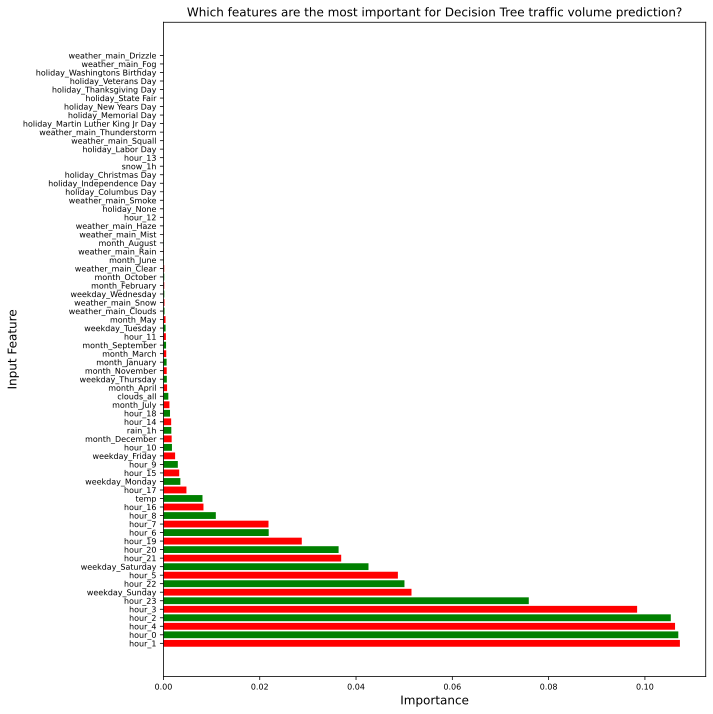

In [25]:
# Storing importance values from the trained model
dt_importance = dt_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
dt_feature_imp = pd.DataFrame(list(zip(train_X.columns, dt_importance)),
               columns = ['Feature', 'Importance'])

dt_feature_imp = dt_feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
dt_fig = plt.figure(figsize=(10, 10))
plt.barh(dt_feature_imp['Feature'], dt_feature_imp['Importance'], color = ['red', 'green'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for Decision Tree traffic volume prediction?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

# Saving Feature Importance Plot
dt_fig.savefig("dt_feature_importance.svg", bbox_inches='tight')

In [15]:
# Creating the file where we want to write the model
dt_pickle = open('decision_tree.pickle', 'wb') 

# Write DT model to the file
pickle.dump(dt_model_cv, dt_pickle) 

# Close the file
dt_pickle.close() 

Random Forest

In [16]:
# Hyperparameter Tuning

# Start with an initial guess for parameters
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(2, 20, num = 10)]

# Minimum number of samples required to split a node
min_samples_split = [5, 10, 20]

# Minimum number of samples required at each leaf node
min_samples_leaf = [5, 10, 20]

# Create the random grid
rf_random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf}

pprint(rf_random_grid)

{'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
 'min_samples_leaf': [5, 10, 20],
 'min_samples_split': [5, 10, 20],
 'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]}


In [17]:
# Call RandomizedSearchCV()
rf_model_cv = RandomizedSearchCV(estimator = rf_regressor, 
                                param_distributions = rf_random_grid,
                                n_iter = 100,
                                scoring = 'r2',
                                cv = folds, 
                                verbose = 1,
                                random_state = 42,
                                n_jobs = -1) # Will utilize all available CPUs 

In [18]:
# Fit the model
start = time.time()            # Start Time
rf_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Training time: 4675.439355611801s


In [19]:
# Return the performance metric score
print('Random Forest Initial score: ', rf_model_cv.best_score_)

# Return set of parameters with the best performance
print('Random Forest Initial parameters: ', rf_model_cv.best_params_)

Random Forest Initial score:  0.9372916801189077
Random Forest Initial parameters:  {'n_estimators': 350, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 20}


In [20]:
# Getting optimal hyperparameter values using Grid Search CV

# Adapt grid based on result from initial Random Search CV
rf_param_grid = {
    'max_depth': [18, 20, 22],
    'min_samples_leaf': [2, 5, 7],
    'min_samples_split': [7, 10, 15],
    'n_estimators': [325, 350, 375]
}

pprint(rf_param_grid)

{'max_depth': [18, 20, 22],
 'min_samples_leaf': [2, 5, 7],
 'min_samples_split': [7, 10, 15],
 'n_estimators': [325, 350, 375]}


In [21]:
# Call GridSearchCV()
rf_model_cv = GridSearchCV(estimator = rf_regressor, 
                        param_grid = rf_param_grid, 
                        scoring= 'r2', 
                        cv = folds, 
                        verbose = 1,
                        n_jobs = -1) # Will utilize all available CPUs 

In [22]:
# Fit the model
start = time.time()            # Start Time
rf_model_cv.fit(train_X, train_y)  
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 81 candidates, totalling 405 fits


Training time: 21674.30096387863s


In [23]:
# Return the improved performance metric score
print('Random Forest Improved score: ', rf_model_cv.best_score_)

# Return the improved set of parameters with the best performance
print('Random Forest Improved parameters: ', rf_model_cv.best_params_)

Random Forest Improved score:  0.9408158630287776
Random Forest Improved parameters:  {'max_depth': 22, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 325}


In [24]:
# Extract the best model from the cross-validated results
best_rf_model = rf_model_cv.best_estimator_

# Make predictions on the test set using the best model
rf_test_predictions = best_rf_model.predict(test_X)

# Calculate RMSE
rf_rmse = np.sqrt(mean_squared_error(test_y, rf_test_predictions))

print('Random Forest Root Mean Squared Error (RMSE) using the best model:', rf_rmse)

Random Forest Root Mean Squared Error (RMSE) using the best model: 469.04863209201454


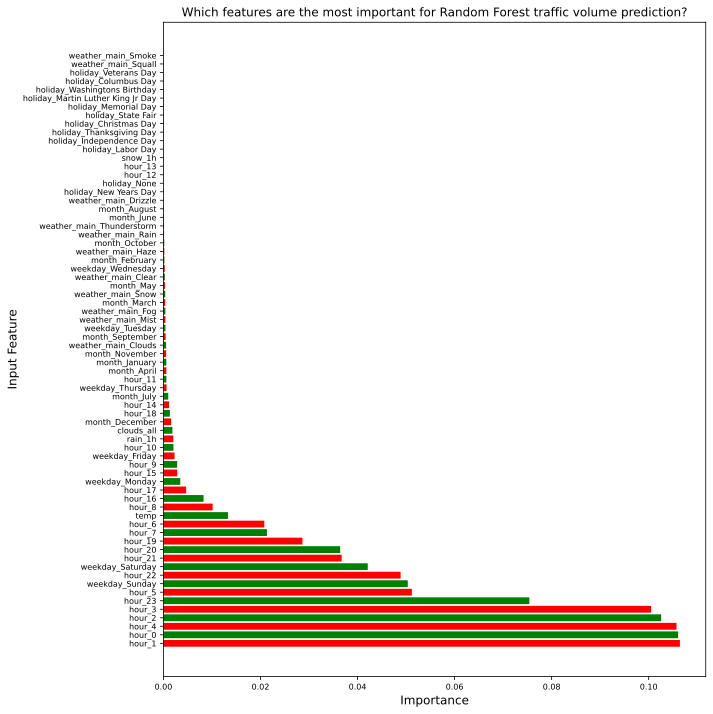

In [26]:
# Storing importance values from the trained model
rf_importance = rf_model_cv.best_estimator_.feature_importances_

# Storing feature importance as a dataframe
rf_feature_imp = pd.DataFrame(list(zip(train_X.columns, rf_importance)),
               columns = ['Feature', 'Importance'])

rf_feature_imp = rf_feature_imp.sort_values('Importance', ascending = False).reset_index(drop = True)

# Bar plot
rf_fig = plt.figure(figsize=(10, 10))
plt.barh(rf_feature_imp['Feature'], rf_feature_imp['Importance'], color = ['red', 'green'])

plt.xlabel("Importance", fontsize = 12)
plt.ylabel("Input Feature", fontsize = 12)
plt.title('Which features are the most important for Random Forest traffic volume prediction?', fontsize = 12) 
plt.yticks(fontsize = 8) # fontsize of yticks
plt.xticks(fontsize = 8) # fontsize of xticks

plt.tight_layout();

# Saving Feature Importance Plot
rf_fig.savefig("rf_feature_importance.svg", bbox_inches='tight')

In [27]:
# Creating the file where we want to write the model
rf_pickle = open('random_forest.pickle', 'wb') 

# Write RF model to the file
pickle.dump(rf_model_cv, rf_pickle) 

# Close the file
rf_pickle.close() 

AdaBoost

In [50]:
# Hyperparameter Tuning for AdaBoost

# Start with an initial guess for parameters using Randomized Cross Validation
ab_hyper_params = {
    'n_estimators': [100, 200, 300, 400, 500],
    'learning_rate': [0.5, 1.0, 1.5, 2.0, 2.5]
}

# Call RandomizedSearchCV() for AdaBoost
ab_model_cv = RandomizedSearchCV(estimator=ab_regressor,
                                 param_distributions=ab_hyper_params,
                                 n_iter=100,
                                 scoring='r2',
                                 cv=folds,
                                 verbose=1,
                                 random_state=42,
                                 n_jobs=-1)  # Will utilize all available CPUs 

In [51]:
# Fit the AdaBoost model
start = time.time()            # Start Time
ab_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 25 candidates, totalling 125 fits
Training time: 1086.8115091323853s


In [52]:
# Return the performance metric score for AdaBoost
print('AdaBoost Initial score: ', ab_model_cv.best_score_)

# Return set of parameters with the best performance for AdaBoost
print('AdaBoost Initial parameters: ', ab_model_cv.best_params_)

AdaBoost Initial score:  0.9455520793655893
AdaBoost Initial parameters:  {'n_estimators': 200, 'learning_rate': 1.0}


In [54]:
# Getting optimal hyperparameter values using Grid Search CV for AdaBoost

# Adapt grid based on result from initial Random Search CV for AdaBoost
ab_hyper_params_new = {
    'n_estimators': [150, 200, 250],
    'learning_rate': [0.75, 1.0, 1.25]
}

# Call GridSearchCV() for AdaBoost
ab_model_cv = GridSearchCV(estimator=ab_regressor,
                           param_grid=ab_hyper_params_new,
                           scoring='r2',
                           cv=folds,
                           verbose=1,
                           n_jobs=-1)  # Will utilize all available CPUs 


In [55]:
# Fit the AdaBoost model with improved hyperparameters
start = time.time()            # Start Time
ab_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Training time: 329.532990694046s


In [56]:
# Return the improved performance metric score for AdaBoost
print('AdaBoost Improved score: ', ab_model_cv.best_score_)

# Return the improved set of parameters with the best performance for AdaBoost
print('AdaBoost Improved parameters: ', ab_model_cv.best_params_)

AdaBoost Improved score:  0.9457777135948804
AdaBoost Improved parameters:  {'learning_rate': 1.0, 'n_estimators': 150}


In [57]:
# Extract the best AdaBoost model from the cross-validated results
best_ab_model = ab_model_cv.best_estimator_

# Make predictions on the test set using the best AdaBoost model
ab_test_predictions = best_ab_model.predict(test_X)

# Calculate RMSE for AdaBoost
ab_rmse = np.sqrt(mean_squared_error(test_y, ab_test_predictions))

print('AdaBoost Root Mean Squared Error (RMSE) using the best model:', ab_rmse)


AdaBoost Root Mean Squared Error (RMSE) using the best model: 440.81543857880496


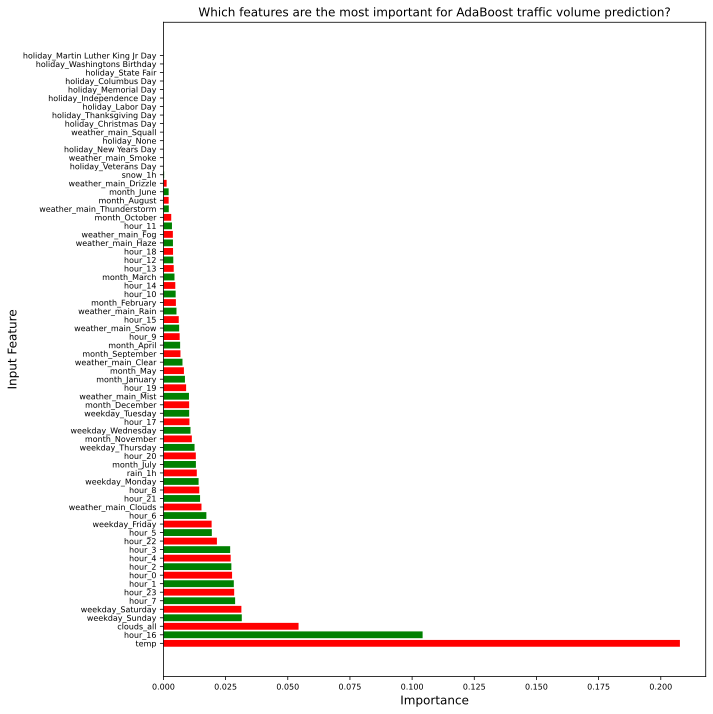

In [58]:
# Storing importance values from the trained AdaBoost model
ab_importance = best_ab_model.feature_importances_

# Storing feature importance as a dataframe for AdaBoost
ab_feature_imp = pd.DataFrame(list(zip(train_X.columns, ab_importance)),
               columns=['Feature', 'Importance'])

ab_feature_imp = ab_feature_imp.sort_values('Importance', ascending=False).reset_index(drop=True)

# Bar plot for AdaBoost
ab_fig = plt.figure(figsize=(10, 10))
plt.barh(ab_feature_imp['Feature'], ab_feature_imp['Importance'], color=['red', 'green'])

plt.xlabel("Importance", fontsize=12)
plt.ylabel("Input Feature", fontsize=12)
plt.title('Which features are the most important for AdaBoost traffic volume prediction?', fontsize=12) 
plt.yticks(fontsize=8) # fontsize of yticks
plt.xticks(fontsize=8) # fontsize of xticks

plt.tight_layout();

# Saving Feature Importance Plot for AdaBoost
ab_fig.savefig("ab_feature_importance.svg", bbox_inches='tight')

In [59]:
# Creating the file where we want to write the AdaBoost model
ab_pickle = open('adaboost.pickle', 'wb') 

# Write AdaBoost model to the file
pickle.dump(ab_model_cv, ab_pickle) 

# Close the file
ab_pickle.close()

XGBoost

In [37]:
# Hyperparameter Tuning for XGBoost

# Start with an initial guess for parameters using Randomized Cross Validation
xgb_hyper_params = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1.0],
    'max_depth': [3, 4, 5]
}

# Call RandomizedSearchCV() for XGBoost
xgb_model_cv = RandomizedSearchCV(estimator=xgb_regressor,
                                   param_distributions=xgb_hyper_params,
                                   n_iter=100,
                                   scoring='r2',
                                   cv=folds,
                                   verbose=1,
                                   random_state=42,
                                   n_jobs=-1)  # Will utilize all available CPUs 

In [38]:
# Fit the XGBoost model
start = time.time()            # Start Time
xgb_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training time: 25.769618272781372s


In [39]:
# Return the performance metric score for XGBoost
print('XGBoost Initial score: ', xgb_model_cv.best_score_)

# Return set of parameters with the best performance for XGBoost
print('XGBoost Initial parameters: ', xgb_model_cv.best_params_)

XGBoost Initial score:  0.9418851868240461
XGBoost Initial parameters:  {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 1.0}


In [40]:
# Getting optimal hyperparameter values using Grid Search CV for XGBoost

# Adapt grid based on result from initial Random Search CV for XGBoost
xgb_hyper_params_new = {
    'n_estimators': [125, 150, 175],
    'learning_rate': [0.5, 1.0, 1.5],
    'max_depth': [2, 3, 4]
}

# Call GridSearchCV() for XGBoost
xgb_model_cv = GridSearchCV(estimator=xgb_regressor,
                            param_grid=xgb_hyper_params_new,
                            scoring='r2',
                            cv=folds,
                            verbose=1,
                            n_jobs=-1)  # Will utilize all available CPUs 

In [41]:
# Fit the XGBoost model with improved hyperparameters
start = time.time()            # Start Time
xgb_model_cv.fit(train_X, train_y)
stop = time.time()             # End Time
print(f"Training time: {stop - start}s")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Training time: 26.08149766921997s


In [42]:
# Return the improved performance metric score for XGBoost
print('XGBoost Improved score: ', xgb_model_cv.best_score_)

# Return the improved set of parameters with the best performance for XGBoost
print('XGBoost Improved parameters: ', xgb_model_cv.best_params_)

XGBoost Improved score:  0.9459408285780639
XGBoost Improved parameters:  {'learning_rate': 0.5, 'max_depth': 4, 'n_estimators': 175}


In [43]:
# Extract the best XGBoost model from the cross-validated results
best_xgb_model = xgb_model_cv.best_estimator_

# Make predictions on the test set using the best XGBoost model
xgb_test_predictions = best_xgb_model.predict(test_X)

# Calculate RMSE for XGBoost
xgb_rmse = np.sqrt(mean_squared_error(test_y, xgb_test_predictions))

print('XGBoost Root Mean Squared Error (RMSE) using the best model:', xgb_rmse)

XGBoost Root Mean Squared Error (RMSE) using the best model: 441.45295362843655


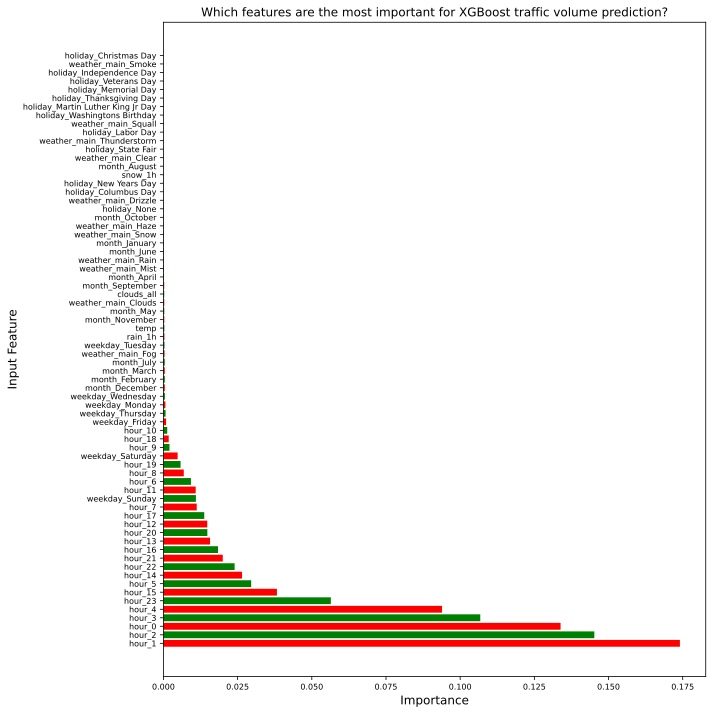

In [44]:
# Storing importance values from the trained XGBoost model
xgb_importance = best_xgb_model.feature_importances_

# Storing feature importance as a dataframe for XGBoost
xgb_feature_imp = pd.DataFrame(list(zip(train_X.columns, xgb_importance)),
               columns=['Feature', 'Importance'])

xgb_feature_imp = xgb_feature_imp.sort_values('Importance', ascending=False).reset_index(drop=True)

# Bar plot for XGBoost
xgb_fig = plt.figure(figsize=(10, 10))
plt.barh(xgb_feature_imp['Feature'], xgb_feature_imp['Importance'], color=['red', 'green'])

plt.xlabel("Importance", fontsize=12)
plt.ylabel("Input Feature", fontsize=12)
plt.title('Which features are the most important for XGBoost traffic volume prediction?', fontsize=12) 
plt.yticks(fontsize=8) # fontsize of yticks
plt.xticks(fontsize=8) # fontsize of xticks

plt.tight_layout();

# Saving Feature Importance Plot for XGBoost
xgb_fig.savefig("xgb_feature_importance.svg", bbox_inches='tight')

In [45]:
# Creating the file where we want to write the XGBoost model
xgb_pickle = open('xgboost.pickle', 'wb') 

# Write XGBoost model to the file
pickle.dump(xgb_model_cv, xgb_pickle) 

# Close the file
xgb_pickle.close()